In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/939.5 kB ? eta -:--:--
     ----------- ---------------------------- 262.1/939.5 kB ? eta -:--:--
     -------------------------------------- 939.5/939.5 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for peewee: filename=peewee-3.17.7-py3-none-any.whl size=138951 sha256=845c65ae90343e2fd2f9ffbfbf5b6b322a3833b82df3f2c6b7ea8c280dd5338f
  Stored in directory: c:\users\dell\appdata\local\pip\cache\wheels\d8\b7\b5\bc5cfc21613ff88ce55cf4151a9f32e23bd8f4a2c4d51e7c8b
Successfully built peewee
Note: you may need to restart the kernel to use updated pa

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
ticker = 'AAPL'  # Apple's stock ticker
stock_data = yf.download(ticker, start='2010-01-01', end='2023-01-01')

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454505,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465665,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351057,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393281,447610800


In [8]:
data = stock_data['Close'].values.reshape(-1, 1)
data

array([[  7.64321423],
       [  7.65642881],
       [  7.53464317],
       ...,
       [126.04000092],
       [129.61000061],
       [129.92999268]])

In [9]:
data2 = stock_data['Close']
data2

Date
2010-01-04      7.643214
2010-01-05      7.656429
2010-01-06      7.534643
2010-01-07      7.520714
2010-01-08      7.570714
                 ...    
2022-12-23    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Name: Close, Length: 3272, dtype: float64

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [11]:
train_size = int(len(scaled_data) * 0.8)  # Use 80% for training
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [12]:
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

In [14]:
time_step = 60  # Use the past 60 days to predict the next day's price
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_test

array([[0.41509066, 0.41464819, 0.42022909, ..., 0.62062752, 0.62145535,
        0.63611416],
       [0.41464819, 0.42022909, 0.42235581, ..., 0.62145535, 0.63611416,
        0.6709127 ],
       [0.42022909, 0.42235581, 0.42489647, ..., 0.63611416, 0.6709127 ,
        0.67940534],
       ...,
       [0.77413784, 0.79497705, 0.79668979, ..., 0.7157882 , 0.71367577,
        0.70322764],
       [0.79497705, 0.79668979, 0.7911517 , ..., 0.71367577, 0.70322764,
        0.68044731],
       [0.79668979, 0.7911517 , 0.76066376, ..., 0.70322764, 0.68044731,
        0.70082972]])

In [15]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_test

array([[[0.41509066],
        [0.41464819],
        [0.42022909],
        ...,
        [0.62062752],
        [0.62145535],
        [0.63611416]],

       [[0.41464819],
        [0.42022909],
        [0.42235581],
        ...,
        [0.62145535],
        [0.63611416],
        [0.6709127 ]],

       [[0.42022909],
        [0.42235581],
        [0.42489647],
        ...,
        [0.63611416],
        [0.6709127 ],
        [0.67940534]],

       ...,

       [[0.77413784],
        [0.79497705],
        [0.79668979],
        ...,
        [0.7157882 ],
        [0.71367577],
        [0.70322764]],

       [[0.79497705],
        [0.79668979],
        [0.7911517 ],
        ...,
        [0.71367577],
        [0.70322764],
        [0.68044731]],

       [[0.79668979],
        [0.7911517 ],
        [0.76066376],
        ...,
        [0.70322764],
        [0.68044731],
        [0.70082972]]])

In [16]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the next price


C:\Users\DELL\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - loss: 0.0069
Epoch 2/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 3.8891e-04
Epoch 3/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 2.9791e-04
Epoch 4/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.5178e-04
Epoch 5/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.8441e-04
Epoch 6/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 2.3545e-04
Epoch 7/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.9884e-04
Epoch 8/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 2.0187e-04
Epoch 9/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.7817e-04
Epoch 10/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.9649e-04
Epoch 11/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.9475e-04
Epoch 12/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 1.6913e-04
Epoch 13/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.5466e-04
Epoch 14/20
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 1.6545e-04
Epoch 15/20
80/80 ━

In [18]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)


80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [19]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
actual_test_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

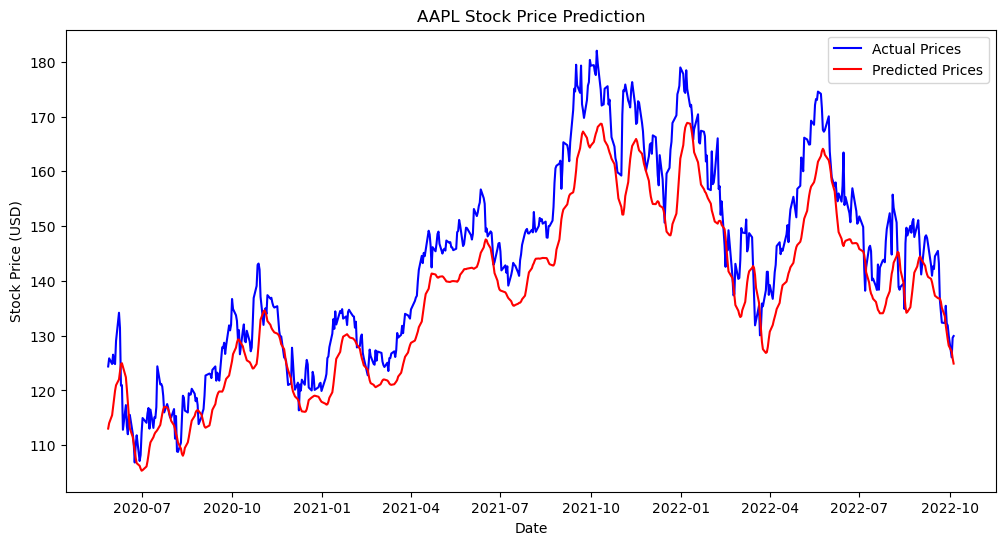

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(stock_data.index[len(train_predict) + time_step:len(train_predict) + time_step + len(test_predict)],
         actual_test_prices, color='blue', label='Actual Prices')
plt.plot(stock_data.index[len(train_predict) + time_step:len(train_predict) + time_step + len(test_predict)],
         test_predict, color='red', label='Predicted Prices')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()